In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


Initialization and abstraction of data

In [2]:
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget


In [3]:
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest


In [4]:
def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target



In [5]:
trainData, validData, testData, trainTarget, validTarget, testTarget= loadData()
train_y, valid_y, test_y = convertOneHot( trainTarget, validTarget, testTarget)
#Train Data 
train_x = trainData.reshape(10000,784)
X0 = np.ones((10000,1))
train_X = np.append(X0,train_x,axis=1)

#Test Data
global test_X
test_X = testData.reshape(2724,784)


#Validation Data
global validation_X
validation_X = validData.reshape(6000,784)
print(train_X.shape)

(10000, 785)


Helper Functions

In [6]:
def relu(x) : 
    return np.maximum(x,0)

In [7]:
def softmax(X):
    exp = np.exp(X)
    denom = np.sum(exp, axis = 1, keepdims=True)
    return exp/denom

In [8]:
def computeLayer(X,W,b) :
    W_new = np.concatenate((b, W))
    return np.dot(X,W_new) 

In [9]:
def CE(y, inputs):
    index = np.argmax(y, axis = 1)
    probability = inputs[np.arange(len(inputs)), index]
    log = np.log(probability)
    CE_out = -1.0 * np.sum(log) / log.shape[0]
    return CE_out

In [10]:
def gradCE(target, prediction):

    # TODO


SyntaxError: unexpected EOF while parsing (<ipython-input-10-c12b5ed612cf>, line 3)

Forward Propagation 

In [10]:
#forward propagation

def forward_pass(X,W,bW,V,bV,out_y) :
    N= X.shape[0]
    s1 = computeLayer(X,W,bW)
    y = relu(s1)
    h0 = np.ones((N,1))
    Y = np.append(h0,y,axis=1)
    S2 = computeLayer(Y,V,bV)
    Z = softmax(S2)
    loss_out = CE(out_y, Z)
    pred_val = np.argmax(Z,1)
    GT = np.argmax(out_y,1)
    acc = np.mean(pred_val == GT)
    return loss_out,s1,Y,S2,Z,acc*100


All Gradients

In [11]:
#### Gradient wrt outer layer weights 
def grad_outer(Y,Z,train_y,S2):
    term_2 = np.copy(Y)
    N = train_y.shape[0]
    L = (1/N)*(Z - train_y)
    tot_Wo = np.dot(term_2.T,L)
    return tot_Wo[0].reshape(1,10),tot_Wo[1:], L


In [12]:
#### Gradient wrt hidden layer weight 
def grad_hidden(train_X,Y,L,V,bV,N):

    term_2 = np.copy(train_X)
    term_1_2 = np.copy(Y[:,1:])
    term_1_2[term_1_2 > 0] = 1
    term_1_1_1 = np.copy(L)
    term_1_1_2_V = np.copy(V)
    term_1_1 = (np.dot(term_1_1_1,term_1_1_2_V.T))
    term_1 = term_1_1 * term_1_2
    tot_Wh = np.matmul(term_2.T,term_1)
    
    
    return tot_Wh[0].reshape(1,N), tot_Wh[1:]

In [13]:
def model(hiddenlayers, learningrate,momentum ):
    
    trainData, validData, testData, trainTarget, validTarget, testTarget= loadData()
    train_y, valid_y, test_y = convertOneHot( trainTarget, validTarget, testTarget)
    
    #Train Data 
    train_x = trainData.reshape(10000,784)
    X0 = np.ones((10000,1))
    train_X = np.append(X0,train_x,axis=1)    
    #Test Data
    test_x = testData.reshape(2724,784)
    X0 = np.ones((2724,1))
    test_X = np.append(X0,test_x,axis=1)
    #Validation Data
    validation_x = validData.reshape(6000,784)
    X0 = np.ones((6000,1))
    validation_X = np.append(X0,validation_x,axis=1) 
    
    #weights and bias from hidden to output layer ---> W,bW
    mu = 0
    sigma =1 /  math.sqrt(784 + hiddenlayers)
    W = np.random.normal(mu, sigma, [784,hiddenlayers])
    bW = np.zeros((1,hiddenlayers))
    #weights and bias from hidden to output layer ---> V,bV
    mu = 0
    sigma =1/ math.sqrt(hiddenlayers + 10)
    V = np.random.normal(mu, sigma, [hiddenlayers,10])
    bV = np.zeros((1,10))
    
    #matrices for momentum 
    mV = np.full((hiddenlayers,10),0.00001)
    mW = np.full((784,hiddenlayers),0.00001)
    mbV = np.full((1,10),0.00001)
    mb = np.full((1,hiddenlayers),0.00001)
    
    #Hyper Parameter
    gamma = momentum
    alpha = learningrate

    train_loss = []
    test_loss = []
    validation_loss = []
    train_accuracy = []
    validation_accuracy = []
    test_accuracy= []
    total_iter=[]

    for i in range(200) :
        total_iter.append(i)
        loss_out,S1,Y,S2,Z,acc = forward_pass(train_X,W,bW,V,bV,train_y)
        format_str = ('Iter: %d, Train loss = %.5f , Train accuracy = %.5f')
        print(format_str % (i, loss_out, acc))
        train_loss.append(loss_out)
        train_accuracy.append(acc)

        loss_out_val,S1_val,Y_val,S2_val,Z_val,acc_val = forward_pass(validation_X,W,bW,V,bV,valid_y)
        format_str = ('Iter: %d, Validation loss = %.5f , Validation accuracy = %.5f')
        print(format_str % (i, loss_out_val, acc_val))
        validation_loss.append(loss_out_val)
        validation_accuracy.append(acc_val)

        loss_out_t,S1_t,Y_t,S2_t,Z_t,acc_t = forward_pass(test_X,W,bW,V,bV,test_y)
        format_str = ('Iter: %d, Test loss = %.5f , Test accuracy = %.5f')
        print(format_str % (i, loss_out_t, acc_t))
        test_loss.append(loss_out_t)
        test_accuracy.append(acc_t)


        tot_bo,tot_Wo,L=grad_outer(Y,Z,train_y,S2)
        mV = (gamma*mV) + (alpha*tot_Wo)
        V = V - mV
        mbV = (gamma*mbV) + (alpha*tot_bo)
        bV = bV - mbV

        tot_outer = np.append(tot_bo,tot_Wo,axis=0)
        tot_bh,tot_Wh=grad_hidden(train_X,Y,L,V,bV,hiddenlayers)
        mW = (gamma*mW) + (alpha*tot_Wh)
        W = W - mW
        mb = (gamma*mb) + (alpha*tot_bh)
        bW = bW - mb
        
    return total_iter,train_loss,train_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy 

In [14]:
def plot_print_accuracy(iterations, pred_train,pred_validation,pred_test) :
    fig, ax = plt.subplots()
    ax.plot(iterations, pred_train,label = 'Train')
    ax.plot(iterations, pred_test,label = 'Test')
    ax.plot(iterations, pred_validation, label = 'Validation')
    
    plt.legend(['Train', 'Validation','Test'], loc='lower right')
    plt.show()
    
    return

In [15]:
def plot_print_loss(iterations, loss_train,loss_validation,loss_test) :
    fig, ax = plt.subplots()
    ax.plot(iterations, loss_train,label = 'Train')
    ax.plot(iterations, loss_test, label = 'Test')
    
    ax.plot(iterations, loss_validation, label = 'Validation')
    plt.legend(['Train', 'Validation','Test'], loc='upper right')

    plt.show()
    return

In [36]:
hiddenlayers = 1000
learningrate = 0.05
#momentum 0.9
total_iter5,train_loss5,train_accuracy5,validation_loss5,validation_accuracy5,test_loss5,test_accuracy5 = model(hiddenlayers, learningrate)

Iter: 0, Train loss = 2.32164 , Train accuracy = 9.08000
Iter: 0, Validation loss = 2.32796 , Validation accuracy = 9.13333
Iter: 0, Test loss = 2.32310 , Test accuracy = 7.89280
--------------------
Iter: 1, Train loss = 2.18538 , Train accuracy = 27.71000
Iter: 1, Validation loss = 2.19268 , Validation accuracy = 27.58333
Iter: 1, Test loss = 2.18606 , Test accuracy = 26.02790
--------------------
Iter: 2, Train loss = 1.99767 , Train accuracy = 42.74000
Iter: 2, Validation loss = 2.00706 , Validation accuracy = 41.83333
Iter: 2, Test loss = 1.99714 , Test accuracy = 41.62996
--------------------
Iter: 3, Train loss = 1.77941 , Train accuracy = 61.05000
Iter: 3, Validation loss = 1.79192 , Validation accuracy = 59.53333
Iter: 3, Test loss = 1.77799 , Test accuracy = 60.31571
--------------------
Iter: 4, Train loss = 1.52735 , Train accuracy = 73.24000
Iter: 4, Validation loss = 1.54318 , Validation accuracy = 71.98333
Iter: 4, Test loss = 1.52571 , Test accuracy = 73.89868
---------

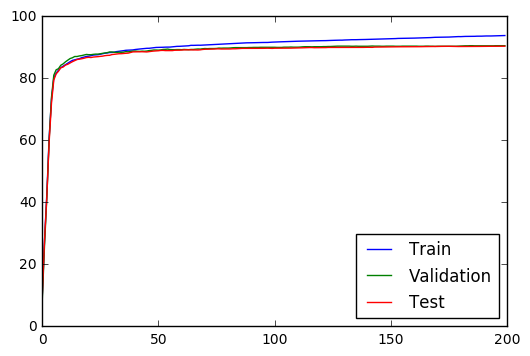

In [37]:
plot_print_accuracy(total_iter5, train_accuracy5,validation_accuracy5,test_accuracy5)

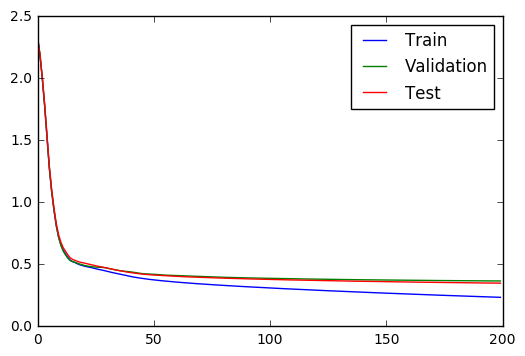

In [38]:
plot_print_loss(total_iter5, train_loss5,validation_loss5,test_loss5)

In [16]:
hiddenlayers = 100
learningrate = 0.05
momentum = 0.9
total_iter2,train_loss2,train_accuracy2,validation_loss2,validation_accuracy2,test_loss2,test_accuracy2 = model(hiddenlayers, learningrate,momentum)

Iter: 0, Train loss = 2.45233 , Train accuracy = 5.56000
Iter: 0, Validation loss = 2.45648 , Validation accuracy = 5.93333
Iter: 0, Test loss = 2.45245 , Test accuracy = 6.05727
--------------------
Iter: 1, Train loss = 2.31310 , Train accuracy = 14.95000
Iter: 1, Validation loss = 2.31964 , Validation accuracy = 15.23333
Iter: 1, Test loss = 2.31225 , Test accuracy = 14.72100
--------------------
Iter: 2, Train loss = 2.17030 , Train accuracy = 28.38000
Iter: 2, Validation loss = 2.17933 , Validation accuracy = 28.70000
Iter: 2, Test loss = 2.16840 , Test accuracy = 28.34068
--------------------
Iter: 3, Train loss = 2.01769 , Train accuracy = 35.11000
Iter: 3, Validation loss = 2.02851 , Validation accuracy = 34.48333
Iter: 3, Test loss = 2.01664 , Test accuracy = 34.80176
--------------------
Iter: 4, Train loss = 1.84718 , Train accuracy = 45.85000
Iter: 4, Validation loss = 1.85908 , Validation accuracy = 43.93333
Iter: 4, Test loss = 1.84740 , Test accuracy = 44.60352
---------

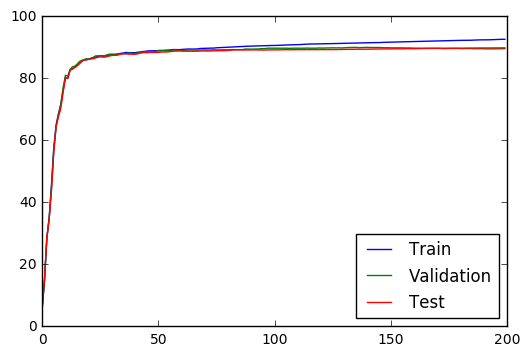

In [17]:
plot_print_accuracy(total_iter2, train_accuracy2,validation_accuracy2,test_accuracy2)

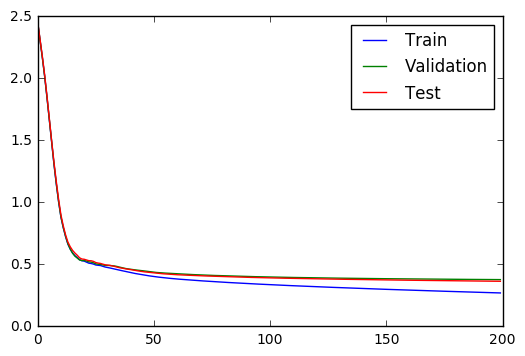

In [18]:
plot_print_loss(total_iter2, train_loss2,validation_loss2,test_loss2)

In [19]:
hiddenlayers = 500
learningrate = 0.05
momentum = 0.9
total_iter3,train_loss3,train_accuracy3,validation_loss3,validation_accuracy3,test_loss3,test_accuracy3 = model(hiddenlayers, learningrate,momentum)

Iter: 0, Train loss = 2.33029 , Train accuracy = 6.95000
Iter: 0, Validation loss = 2.33528 , Validation accuracy = 6.66667
Iter: 0, Test loss = 2.32864 , Test accuracy = 6.90162
--------------------
Iter: 1, Train loss = 2.21955 , Train accuracy = 17.47000
Iter: 1, Validation loss = 2.22440 , Validation accuracy = 17.13333
Iter: 1, Test loss = 2.21783 , Test accuracy = 17.07048
--------------------
Iter: 2, Train loss = 2.04351 , Train accuracy = 44.10000
Iter: 2, Validation loss = 2.04860 , Validation accuracy = 42.75000
Iter: 2, Test loss = 2.04190 , Test accuracy = 44.23642
--------------------
Iter: 3, Train loss = 1.83088 , Train accuracy = 61.01000
Iter: 3, Validation loss = 1.83717 , Validation accuracy = 60.03333
Iter: 3, Test loss = 1.82985 , Test accuracy = 62.04112
--------------------
Iter: 4, Train loss = 1.59650 , Train accuracy = 71.81000
Iter: 4, Validation loss = 1.60555 , Validation accuracy = 70.76667
Iter: 4, Test loss = 1.59638 , Test accuracy = 72.06314
---------

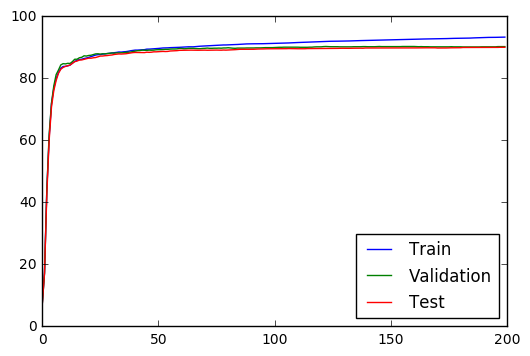

In [20]:
plot_print_accuracy(total_iter3, train_accuracy3,validation_accuracy3,test_accuracy3)

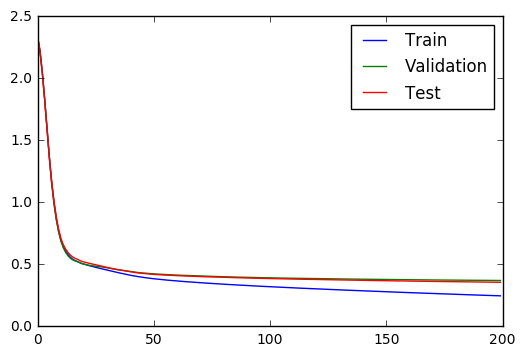

In [21]:
plot_print_loss(total_iter3, train_loss3,validation_loss3,test_loss3)

In [22]:
hiddenlayers = 2000
learningrate = 0.05
momentum = 0.9
total_iter4,train_loss4,train_accuracy4,validation_loss4,validation_accuracy4,test_loss4,test_accuracy4 = model(hiddenlayers, learningrate,momentum)

Iter: 0, Train loss = 2.36823 , Train accuracy = 6.99000
Iter: 0, Validation loss = 2.36992 , Validation accuracy = 6.56667
Iter: 0, Test loss = 2.36843 , Test accuracy = 6.49780
--------------------
Iter: 1, Train loss = 2.20934 , Train accuracy = 23.60000
Iter: 1, Validation loss = 2.21345 , Validation accuracy = 22.46667
Iter: 1, Test loss = 2.20797 , Test accuracy = 23.67841
--------------------
Iter: 2, Train loss = 2.01515 , Train accuracy = 34.53000
Iter: 2, Validation loss = 2.02356 , Validation accuracy = 33.90000
Iter: 2, Test loss = 2.01259 , Test accuracy = 35.13216
--------------------
Iter: 3, Train loss = 1.77210 , Train accuracy = 54.37000
Iter: 3, Validation loss = 1.78444 , Validation accuracy = 53.88333
Iter: 3, Test loss = 1.76952 , Test accuracy = 55.35977
--------------------
Iter: 4, Train loss = 1.48550 , Train accuracy = 77.89000
Iter: 4, Validation loss = 1.50009 , Validation accuracy = 77.60000
Iter: 4, Test loss = 1.48430 , Test accuracy = 78.63436
---------

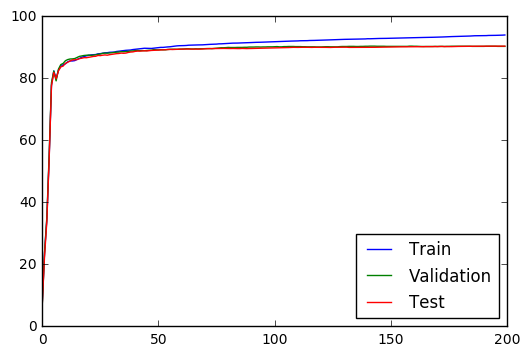

In [23]:
plot_print_accuracy(total_iter4, train_accuracy4,validation_accuracy4,test_accuracy4)

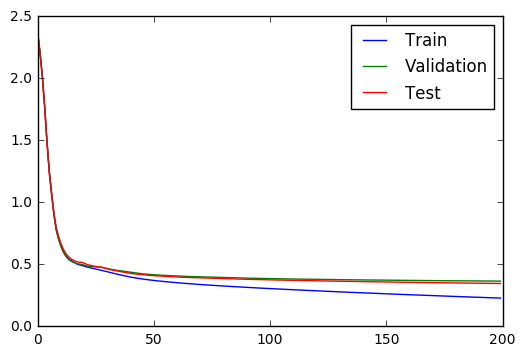

In [24]:
plot_print_loss(total_iter4, train_loss4,validation_loss4,test_loss4)